In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import warnings
warnings.filterwarnings('ignore')
from more_itertools import chunked
# import all relevant func and modules from a companion .py file
from supp_lib import *
# import all samples as dictionary ...
from samples import *

In [4]:
# G4-seq : G4 stalled at polymerase, more comprehensive list (hg19):
# G4-seq data https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE63874
# ls ../GSE*bed.gz
# require tr -s '\t' - to remove duplicated tabs
# we've got + and - strand G4s separately ...
G4_minus_polstall = bioframe.read_table(
    "../GSE63874_Na_K_PDS_minus_hits_intersect.bed.gz",
    names=["chrom","start","end"],
    sep="\t",
    index_col = None
)
G4_plus_polstall = bioframe.read_table(
    "../GSE63874_Na_K_PDS_plus_hits_intersect.bed.gz",
    names=["chrom","start","end"],
    sep="\t",
    index_col = None
)
G4_plus_polstall = G4_plus_polstall.sort_values(["chrom","start"])
G4_plus_polstall = G4_plus_polstall[ G4_plus_polstall["chrom"].isin(autosomal_chroms) ]
G4_plus_polstall = G4_plus_polstall.reset_index(drop=True)
print(f"G4+ alone {len(G4_plus_polstall)} ...")

G4_minus_polstall = G4_minus_polstall.sort_values(["chrom","start"])
G4_minus_polstall = G4_minus_polstall[ G4_minus_polstall["chrom"].isin(autosomal_chroms) ]
G4_minus_polstall = G4_minus_polstall.reset_index(drop=True)
print(f"G4- alone {len(G4_minus_polstall)} ...")

G4_polstall = bf.merge(
    pd.concat([G4_plus_polstall,G4_minus_polstall]).reset_index(drop=True), # !!! Achtung !!! resetting_index is Yber important here!
#     min_dist=merge_radius
)
G4_polstall = G4_polstall.sort_values(["chrom","start"]).reset_index(drop=True)
print(f"G4-+ together {len(G4_polstall)}, would have been {len(G4_plus_polstall)+len(G4_minus_polstall)} ...")

G4+ alone 198824 ...
G4- alone 195394 ...
G4-+ together 378344, would have been 394218 ...


### Figure 2 is based on several important BED-files ...

In [5]:
feat_names = OrderedDict()
feat_names["ctcf"] = "intersect-all-NT-CTCF-NO-G4-centered"
feat_names["ctcf_g4"] = "intersect-all-NT-CTCF-G4-centered"
feat_names["g4"] = "intersect-G4-NO-CTCF-centered"
feat_names["allg4"] = "G4-Mao-sort"

## Read `feature_of_interest` that we want to look at using stackups ...
### we can also generate some random locations from hg19 using `generate_random_bed` ...

In [6]:
G4df = bf.read_table(
    feat_names["g4"],
    names=["chrom","start","end"],
    usecols=(0,1,2),
    index_col=None
)
G4df = G4df.sort_values(["chrom","start"])
G4df = G4df[G4df["chrom"].isin(autosomal_chroms)]
G4df = G4df.reset_index(drop=True)
# g4p = bioframe.overlap(G4df,G4_plus_polstall,keep_order=True)
# g4m = bioframe.overlap(G4df,G4_minus_polstall,keep_order=True)
# pd.merge(g4m,g4p,on=["chrom_1","start_1","end_1"],suffixes=('_m', '_p')).dropna(how="all",subset=["chrom_2_m","start_2_m","end_2_m","chrom_2_p","start_2_p","end_2_p"])

In [7]:
# clean list of G4 chipseq peaks for which we can assign strand based on G4-stall data
g4p = bioframe.overlap(G4df,G4_plus_polstall,how="inner",keep_order=True,suffixes=("","_stall"))[["chrom","start","end"]] \
    .drop_duplicates() \
    .reset_index(drop=True)

# clean list of G4 chipseq peaks for which we can assign strand based on G4-stall data
g4m = bioframe.overlap(G4df,G4_minus_polstall,how="inner",keep_order=True,suffixes=("","_stall"))[["chrom","start","end"]] \
    .drop_duplicates() \
    .reset_index(drop=True)

print(f"we got {len(g4p)} +-s and {len(g4m)} --s")

# subtract them from each other to find G4-chipseq peaks that have a unique strand orientation:
_g4p = bioframe.subtract(g4p,g4m).reset_index(drop=True)
_g4m = bioframe.subtract(g4m,g4p).reset_index(drop=True)
# back to nice names after temporary ...
g4p = _g4p
g4m = _g4m
print(f"we got {len(g4p)} +-s and {len(g4m)} --s")

we got 1615 +-s and 1596 --s
we got 1205 +-s and 1186 --s


In [8]:
# bf is short for bioframe here ...
dfs = OrderedDict()
for k in feat_names:
    dfs[k] = bf.read_table(
        feat_names[k],
        names=["chrom","start","end"],
        usecols=(0,1,2),
        index_col=None
    )
    dfs[k] = dfs[k].sort_values(["chrom","start"])
    dfs[k] = dfs[k][dfs[k]["chrom"].isin(autosomal_chroms)]
    dfs[k] = dfs[k].reset_index(drop=True)
# merge_radius = 500
# df_merged = bf.merge(df, min_dist=merge_radius)
# print(f"number of candidate features before and after merging: {len(df)} -> {len(df_merged)}")


feat_names["g4p"] = "intersect-G4-NO-CTCF-centered"
feat_names["g4m"] = "intersect-G4-NO-CTCF-centered"
dfs["g4p"] = g4p
dfs["g4m"] = g4m


### explore spacing and footprints of the features being explored ...

simply plot distributions of the spacings between adjacent features and their sizes `end - start`  as well ...


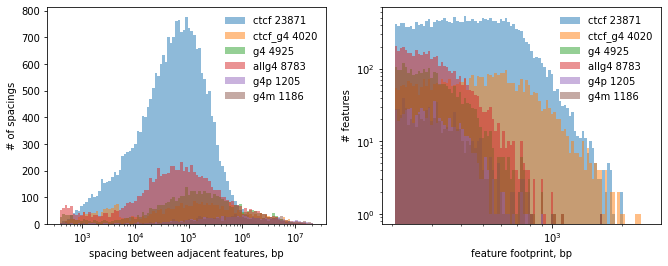

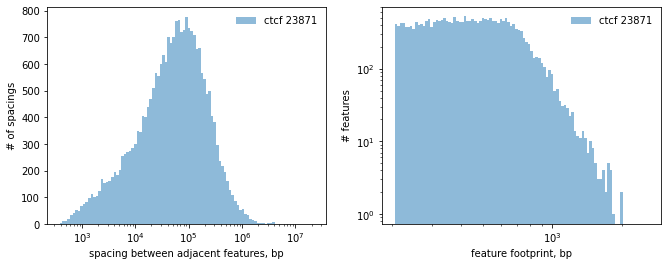

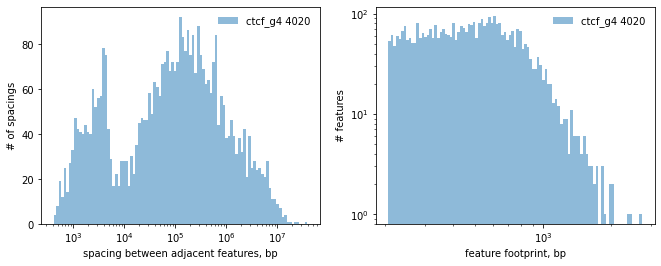

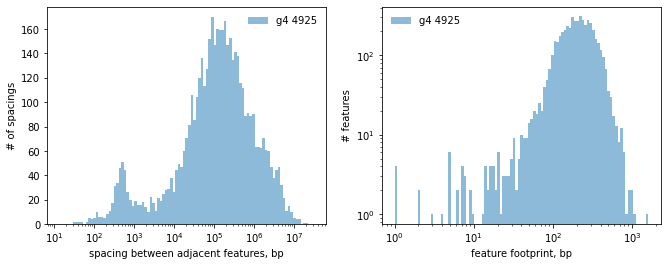

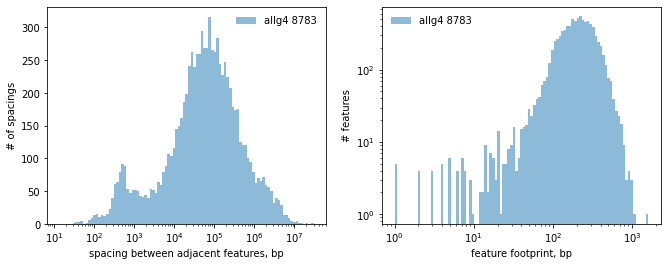

In [9]:
# just an overview of all of them together ...
plot_spacing_footprint_distros(dfs)
plot_spacing_footprint_distros({k:dfs[k] for k in ['ctcf']})
plot_spacing_footprint_distros({k:dfs[k] for k in ['ctcf_g4']})
plot_spacing_footprint_distros({k:dfs[k] for k in ['g4']})
plot_spacing_footprint_distros({k:dfs[k] for k in ['allg4']})

### in our analyses (insulation/compartments) we wouldn't resolve features that are too close ...
#### let's see what clustering those adjacent ones could do for us
#### let's try to pick a good clustering "radius" first - should be  around ~1-10kb ...

it's actually merging that we're doing - i.e. we don't need to know cluster information - just need to collapse nearby intervals into larger ones

to see how varying clustering radius affects the results see the gist : blah ...

### Not sure if we'd need to do it here, given the lare footprint of the G4 related peaks !!!...

### after we explored how our features (intervals) are spaced and distributed
#### we can move on to the stackups - for different samples, different types of tracks, etc

In [10]:
#let's describe our samples that we want to have in Figure 1 ...
fig2_samples = ["ctcf","noctcf","rad21_CTCF","rad21_noCTCF","ins_CTCF","ins_noCTCF","G4a_r2","polII","mrna_ctcf","mrna_noctcf"] #,"ddx_CTCF","ddx_noCTCF"]

titles = fig2_samples

bw_fnames = OrderedDict()
binsizes = {}
flanks = {}
limss = {}
cmps = {}
norms = {}
for s in fig2_samples:
    bw_fnames[s] = samples[s]["fname"]
    binsizes[s] = samples[s]["binsize"]
    flanks[s] = samples[s]["flank"]
    limss[s] = samples[s]["crange"]
    cmps[s] = samples[s]["cmap"]
    norms[s] = None

### next is computation heavy step - stackups using bbi ...

In [11]:
# do all stackups with the parameters ...
stackup_dict = OrderedDict()
for k in dfs:
    stackups = {}
    print(f"going to stackup features {k}:({len(dfs[k])}) ...\n\n")
    for s in bw_fnames:
        print(f"stacking up {s} ...")
        %time stackups[s] = rstacks( bw_fnames[s], dfs[k], flank=flanks[s], binsize=binsizes[s], fill_missing=np.nan )
    stackup_dict[k] = stackups

going to stackup features ctcf:(23871) ...


stacking up ctcf ...
CPU times: user 3.58 s, sys: 227 ms, total: 3.81 s
Wall time: 3.81 s
stacking up noctcf ...
CPU times: user 3.42 s, sys: 193 ms, total: 3.62 s
Wall time: 3.63 s
stacking up rad21_CTCF ...
CPU times: user 3.72 s, sys: 260 ms, total: 3.98 s
Wall time: 4.02 s
stacking up rad21_noCTCF ...
CPU times: user 2.95 s, sys: 140 ms, total: 3.09 s
Wall time: 3.09 s
stacking up ins_CTCF ...
CPU times: user 2.77 s, sys: 165 ms, total: 2.93 s
Wall time: 2.92 s
stacking up ins_noCTCF ...
CPU times: user 2.52 s, sys: 137 ms, total: 2.66 s
Wall time: 2.65 s
stacking up G4a_r2 ...
CPU times: user 4.32 s, sys: 229 ms, total: 4.55 s
Wall time: 4.6 s
stacking up polII ...
CPU times: user 2.61 s, sys: 183 ms, total: 2.79 s
Wall time: 2.79 s
stacking up mrna_ctcf ...
CPU times: user 2.2 s, sys: 172 ms, total: 2.37 s
Wall time: 2.4 s
stacking up mrna_noctcf ...
CPU times: user 2.18 s, sys: 176 ms, total: 2.35 s
Wall time: 2.37 s
going to stackup 

## we'll try 4C stackup visualization next

In [29]:
import cooler
# CkoCT442-IAA-pool.mcool
# CkoCT442-NT-pool.mcool

In [84]:
# Use bioframe to fetch the genomic features from the UCSC.

hg19_chromsizes = bioframe.fetch_chromsizes('hg19', as_bed=True)
hg19_cens = bioframe.fetch_centromeres('hg19')
hg19_arms = bioframe.split(hg19_chromsizes, hg19_cens, cols_points=['chrom', 'mid'])

# Select only arms of the chromosomes present in the cooler. 
# This step is typically not required; we call it only because the test data are reduced. 
hg19_arms = hg19_arms.set_index("chrom").loc[autosomal_chroms].reset_index()
# call this to automaticly assign names to chromosomal arms:
hg19_arms = bioframe.parse_regions(hg19_arms)
# give concise names to chromosomal arms (p for short arm and q for long arm),
# this should be correct because chromosomes are ordered as in clr.chromnames and p->q is
# in the order of genomic coordinates:
hg19_arms["name"] = [f"{chrom}_{arm}" for chrom in autosomal_chroms for arm in list('pq')]
# # save it as a BED file
hg19_arms.to_csv("autosomal_hg19_arms.bed",sep="\t",index=False,header=False)

In [356]:
ls CkoCT442*mcool

CkoCT442-AAVS1sg2-4-NT-R1-T1__hg19.hg19.mapq_30.1000.mcool
CkoCT442-DDX55sg2-B-NT-R1-T1__hg19.hg19.mapq_30.1000.mcool
CkoCT442-IAA-pool.mcool
CkoCT442-NT-pool.mcool


In [357]:
binsize = 10_000
fname = "CkoCT442-NT-pool.mcool"
clr_uri = f"{fname}::/resolutions/{binsize}"
clr = cooler.Cooler(clr_uri)

fname = "CkoCT442-IAA-pool.mcool"
clr_iaa_uri = f"{fname}::/resolutions/{binsize}"
clr_iaa = cooler.Cooler(clr_iaa_uri)

In [358]:
def get_4cstackup(clr, features_df, binsize=None, flank=5000, fill_missing=np.nan, ignore_diags=2):
    """
    extract 4C profiles (3-bin averaged values along the rows of Hi-C matrix) for
    "small" genomic intervals in features_df ("small" ~<  binsize).
    
    This gets tricky very quickly ! (mostly because of edge-cases
    - features near chromosome starts and ends ...)
    
    To be safe, robust and reliable we do it in several steps:
     - align features with the bins of the cooler. 1 feature -> 1 bin
     - expand features according to flank, minding the chromosomal limits !
     - for every expanded feature extract a 4C profile and assign to mat separately
       for left and right "halfs" to avoid edge-case type of issues ...
       
    the center column of the returned mat corresponds to the main diagonal of Hi-C matrix
    """
    if binsize is None:
        binsize = clr.binsize
    # flank - should be multiples of binsize ...
    assert flank % binsize == 0
    flank_bins = flank // binsize
    
    # align features with the bins
    anchor_center_aligned = .5*(features_df["start"]+features_df["end"])
    anchor_center_aligned = binsize * (anchor_center_aligned/binsize).astype(int)
    #
    anchor_df = copy(features_df) # we'll be modifying it ...
    anchor_df["start"] = anchor_center_aligned
    anchor_df["end"]   = anchor_center_aligned + binsize # edge effects isn't fully solved
    
    # prepare an output matrix:
    mat = np.full((2*flank_bins+1, len(anchor_df)), fill_missing, "float")
    
    # dealing with features close to chromosome ends and starts using bioframe:
    expand_anchor_df = bioframe.expand(
        copy(anchor_df), # importan ! otherwise anchor_df is modified inplace !
        flank,
        limits=clr.chromsizes.to_dict(),
    )
    
    for n in expand_anchor_df.itertuples(index=True):
        # coordinates of an expanded anchor:
        i,c,s,e = n
        # coordinates of the true-central bin:
        _c,_s,_e = anchor_df.loc[i] # need this to deal with edge-effects
        # extract bin ids of those:
        icenter = clr.offset((_c,_s,_e))
        ifrom, ito = clr.extent((c,s,e))
        # extract a row of a Hi-C matrix (3-rows average, actually) for the expanded range:
        mat_row = np.nanmean(clr.matrix()[icenter-1:icenter+2, ifrom:ito], axis=0)
        # now carefully assign that to the "empty" mat - dealing with edge cases
        left_half = (ifrom - icenter + flank_bins, 0 + flank_bins) # relative to mat
        right_half = (0 + flank_bins, ito - icenter + flank_bins) # relative to mat
        # that's it:
        mat[slice(*left_half),i] = mat_row[:(icenter - ifrom)]
        mat[slice(*right_half),i] = mat_row[(icenter - ito):]
    # ignore diags ...
    for i in range(ignore_diags):
        mat[flank_bins + i] = np.nan
        mat[flank_bins - i] = np.nan
    #return output
    return mat.T


In [262]:
_k = "ctcf"
mmm = get_4cstackup(clr, dfs[_k], flank=100_000)

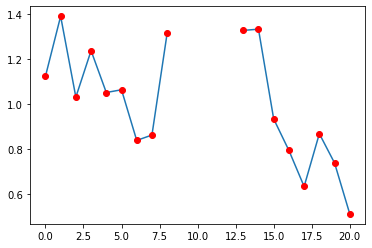

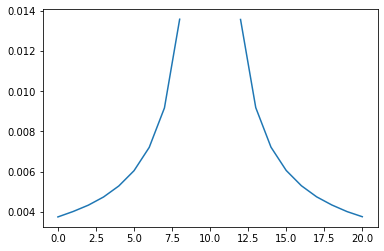

In [263]:
oe = (mmm.T/np.nanmean(mmm.T,axis=0))
plt.figure()
plt.plot(oe[300,:])
plt.plot(mmm.T[300,:]/np.nanmean(mmm.T,axis=0),'ro')
plt.figure()
plt.plot(np.nanmean(mmm.T,axis=0))


In [246]:
oe = (mat.T/np.nanmean(mat.T,axis=0))

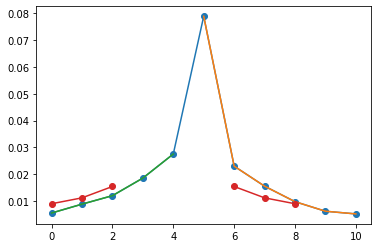

In [162]:
ifr,ito = clr.extent((c,s,e))
ice = clr.offset(( c,int(.5*(s+e)),int(.5*(s+e)) ))
# ice = int(.5*(ifr+ito))
mmm = clr.matrix()[ice,ifr:ito][0]
plt.plot(mmm,'o-')
plt.plot(np.arange(len(mmm))[ice-ifr:ito-ifr],mmm[ice-ifr:ito-ifr])
plt.plot(np.arange(len(mmm))[0:ice-ifr],mmm[0:ice-ifr])

eee = grp.get_group("chr19_p").set_index("diag")["balanced.avg"].values[0:ice-ifr]
eee = np.r_[eee[::-1],eee[1:]]
plt.plot(eee,'o-')

### Normalize insulation stackups - subtract some value from each row in the stackup ...

In [229]:
# normalize all of the insulation stackups for all of the features lists
insulation_keys = [_k for _k in bw_fnames.keys() if _k.startswith("ins")]

# subtract = "mean_top"
# subtract_size = 7
for feature_key in stackup_dict:
    normalize_insulation_stackups_INPLACE(
        stackups_set = stackup_dict[feature_key],
        ins_keys = insulation_keys
    )

In [230]:
# ADJUST COLOMAP FOR INSULATION AND ADJUST VMIN/VMAX FOR THE INSULATION AS WELL ....
# insulation
for s in insulation_keys:
    limss[s] = (-.452,-.153)
    cmps[s] = cmapYlGnBu_r

In [231]:
# turn RNA-seq into log-scale ... - probably should use "norm" instead !!!!
for s in ["mrna_ctcf", "mrna_noctcf"]:
    limss[s] = (0.,3)    

for k in dfs:
    for s in ["mrna_ctcf", "mrna_noctcf"]:
        stackup_dict[k][s] = np.log(stackup_dict[k][s])


In [388]:
# LET'S ADD GENES AS YET ANOTHER STACKUP TO THE DICT ...
annot_flank = 100_000
annot_binsize = 1000
feat_name = "wide_gene"
for k in dfs:
    print(f"stacking genes up for {k} ...")
    aaa = rstacks(
        "pcgene_plus.bb",
        dfs[k],
        flank=annot_flank,
        binsize=annot_binsize,
    )
    bbb = rstacks(
        "pcgene_minus.bb",
        dfs[k],
        flank=annot_flank,
        binsize=annot_binsize,
    )
    stackup_dict[k][feat_name] = aaa - bbb

    
#let's describe our samples that we want to have in Figure 1 ...
fig2_samples.append(feat_name)
titles = fig2_samples

s = feat_name
bw_fnames[s] = "blah"
binsizes[s] = annot_binsize
flanks[s] = annot_flank
limss[s] = (-1,1)
cmps[s] = "coolwarm"
norms[s] = None

stacking genes up for ctcf ...
stacking genes up for ctcf_g4 ...
stacking genes up for g4 ...
stacking genes up for allg4 ...
stacking genes up for g4p ...
stacking genes up for g4m ...


In [364]:
# takes a long time to compute !!!
# LET'S ADD Hi-C data AS YET ANOTHER STACKUP TO THE DICT ...
hic_flank = 100_000
for k in dfs:
    print(f"stacking 4C nt up for {k} ...")
    stackup_dict[k]["hic_nt"] = get_4cstackup(clr, dfs[k], flank=hic_flank)
    print(f"stacking 4C aux up for {k} ...")
    stackup_dict[k]["hic_aux"] = get_4cstackup(clr_iaa, dfs[k], flank=hic_flank)


stacking 4C nt up for ctcf ...
stacking 4C aux up for ctcf ...
stacking 4C nt up for ctcf_g4 ...
stacking 4C aux up for ctcf_g4 ...
stacking 4C nt up for g4 ...
stacking 4C aux up for g4 ...
stacking 4C nt up for allg4 ...
stacking 4C aux up for allg4 ...
stacking 4C nt up for g4p ...
stacking 4C aux up for g4p ...
stacking 4C nt up for g4m ...
stacking 4C aux up for g4m ...


In [389]:
#let's describe our samples that we want to have in Figure 1 ...
for s in ["hic_nt","hic_aux"]:
    fig2_samples.append(s)
    bw_fnames[s] = "coolerfname"
    binsizes[s] = clr.binsize # change to dict of coolers ...
    flanks[s] = hic_flank
    # for the Hi-C signal itself:
    limss[s] = (None,None)
    cmps[s] = "YlOrBr"
    norms[s] = colors.LogNorm(vmin=0.002,vmax=0.05)

titles = fig2_samples


In [390]:
# # LET'S ADD Hi-C data AS YET ANOTHER STACKUP TO THE DICT ...
# # hic_flank = 100_000

for s in ["hic_nt","hic_aux"]:
    # get average 4C profile - aka expected
    average_4C = []
    for k in ['ctcf', 'ctcf_g4', 'g4']:
        _ = np.nanmean( stackup_dict[k][s], axis=0 )
        average_4C.append(_)
    average_4C = np.nanmean(np.stack(average_4C),axis=0)
    # modify 4C stackups a bit ...
    for k in dfs:
        print(f"stacking 4C up for {k} ...")
        stackup_dict[k][f"{s}_oe"] = (stackup_dict[k][s]/average_4C)


#let's describe our samples that we want to have in Figure 1 ...
for s in ["hic_nt","hic_aux"]:
    s = f"{s}_oe"
    fig2_samples.append(s)
    bw_fnames[s] = "coolerfname"
    binsizes[s] = clr.binsize # change to dict of coolers ...
    flanks[s] = hic_flank
    # for Observed over Expected:
    limss[s] = (0,2)
    cmps[s] = "coolwarm"
    norms[s] = None
    titles = fig2_samples


stacking 4C up for ctcf ...
stacking 4C up for ctcf_g4 ...
stacking 4C up for g4 ...
stacking 4C up for allg4 ...
stacking 4C up for g4p ...
stacking 4C up for g4m ...
stacking 4C up for ctcf ...
stacking 4C up for ctcf_g4 ...
stacking 4C up for g4 ...
stacking 4C up for allg4 ...
stacking 4C up for g4p ...
stacking 4C up for g4m ...


In [393]:
# NOW REORDER A STACKUPS FOR EACH FEATURE ACCORDING TO SOMETHING ....
reordered_jdxs = OrderedDict()
for feature_key in stackup_dict:
    the_stackups = stackup_dict[feature_key]
    # for a given set of stackups for a given list of features ...
    length,width = the_stackups['ctcf'].shape
    center_bin = int(width/2)
    the_stackups['ctcf_mean'] = np.nanmean(the_stackups['ctcf'][:,center_bin-1:center_bin+1],axis=1)
    # the_stackups['gene_mean'] = np.nanmean(the_stackups['gene'][:,:],axis=1)
    # the_stackups['rad21_mean'] = np.nanmean(the_stackups['rad21_CTCF'][:,center_bin-2:center_bin+2],axis=1)
    _, _jjj = recursive_data_ordering(
        ks = [('ctcf_mean', "sort", 1, False)],
        idxs = np.arange( len(the_stackups['ctcf_mean']) ),
        data_dict = the_stackups,
        verbose=True
    )
    reordered_jdxs[feature_key] = _jjj


sorting 23871 elements of ctcf_mean into 1 groups ...
sorting 4020 elements of ctcf_mean into 1 groups ...
sorting 4925 elements of ctcf_mean into 1 groups ...
sorting 8783 elements of ctcf_mean into 1 groups ...
sorting 1205 elements of ctcf_mean into 1 groups ...
sorting 1186 elements of ctcf_mean into 1 groups ...


### calculate running average (in chunks of 100) number of called peaks along the stackup

In [394]:
# #
# # skipping this for now ....
# #
CHUNK_SIZE = 100
# index_chunks = chunked(df_merged.loc[jjj].index, CHUNK_SIZE)
# ctcf_peaks_sorted = []
# for ii in index_chunks:
#     _df1 = df_merged.loc[ii][["chrom","start","end"]].reset_index(drop=True)
#     _df2 = ctcf_df
#     ctcf_peaks_sorted.append(bioframe.count_overlaps(_df1, _df2 )["count"].sum())
    
# index_chunks = chunked(df_merged.loc[jjj].index, CHUNK_SIZE)
# rad21_peaks_sorted = []
# for ii in index_chunks:
#     _df1 = df_merged.loc[ii][["chrom","start","end"]].reset_index(drop=True)
#     _df2 = rad21_df
#     rad21_peaks_sorted.append(bioframe.count_overlaps(_df1, _df2 )["count"].sum())
    
# index_chunks = chunked(df_merged.loc[jjj].index, CHUNK_SIZE)
# rad21IAA_peaks_sorted = []
# for ii in index_chunks:
#     _df1 = df_merged.loc[ii][["chrom","start","end"]].reset_index(drop=True)
#     _df2 = rad21_IAA_df
#     rad21IAA_peaks_sorted.append(bioframe.count_overlaps(_df1, _df2 )["count"].sum())

# G4_polstall_sorted = {}
# Number_of_chunks = {}
# for feature_key in ['ctcf', 'ctcf_g4', 'g4',"g4p","g4m"]:
#     jjj = reordered_jdxs[feature_key]
#     features_df = dfs[feature_key]
#     # G4_polstall
#     index_chunks = chunked(features_df.loc[jjj].index, CHUNK_SIZE)
#     G4_polstall_sorted[feature_key] = []
#     Number_of_chunks[feature_key] = 0
#     _df2 = G4_minus_polstall # works as is !!!
#     for ii in index_chunks:
#         _df1 = features_df.loc[ii][["chrom","start","end"]].reset_index(drop=True)
#         G4_polstall_sorted[feature_key].append(bioframe.count_overlaps(_df1, _df2 )["count"].sum())
#         Number_of_chunks[feature_key] += 1
        
G4p_sorted = {}
Number_of_chunks = {}
for feature_key in ['ctcf', 'ctcf_g4', 'g4',"g4p","g4m"]:
    jjj = reordered_jdxs[feature_key]
    features_df = dfs[feature_key]
    # G4_polstall
    index_chunks = chunked(features_df.loc[jjj].index, CHUNK_SIZE)
    G4p_sorted[feature_key] = []
    Number_of_chunks[feature_key] = 0
    _df2 = G4_plus_polstall # works as is !!!
    for ii in index_chunks:
        _df1 = features_df.loc[ii][["chrom","start","end"]].reset_index(drop=True)
        G4p_sorted[feature_key].append(bioframe.count_overlaps(_df1, _df2 )["count"].sum())
        Number_of_chunks[feature_key] += 1
        
G4m_sorted = {}
Number_of_chunks = {}
for feature_key in ['ctcf', 'ctcf_g4', 'g4',"g4p","g4m"]:
    jjj = reordered_jdxs[feature_key]
    features_df = dfs[feature_key]
    # G4_polstall
    index_chunks = chunked(features_df.loc[jjj].index, CHUNK_SIZE)
    G4m_sorted[feature_key] = []
    Number_of_chunks[feature_key] = 0
    _df2 = G4_minus_polstall # works as is !!!
    for ii in index_chunks:
        _df1 = features_df.loc[ii][["chrom","start","end"]].reset_index(drop=True)
        G4m_sorted[feature_key].append(bioframe.count_overlaps(_df1, _df2 )["count"].sum())
        Number_of_chunks[feature_key] += 1

#### plotting those running averages is integrated into `plot_stackups` function ...

In [395]:
##############################################
# now we'll be plotting stackups for different feature independently ...
#############################################
print('ctcf', 'ctcf_g4', 'g4')

ctcf ctcf_g4 g4


(0, 2.2)
(0, 2.2)
(0, 0.4)
(0, 0.4)
(-0.452, -0.153)
(-0.452, -0.153)
(0, 30)
(0, 0.7)
(0.0, 3)
(0.0, 3)
(-1, 1)
(-1, 1)
(None, None)
(None, None)
(0, 2)
(0, 2)


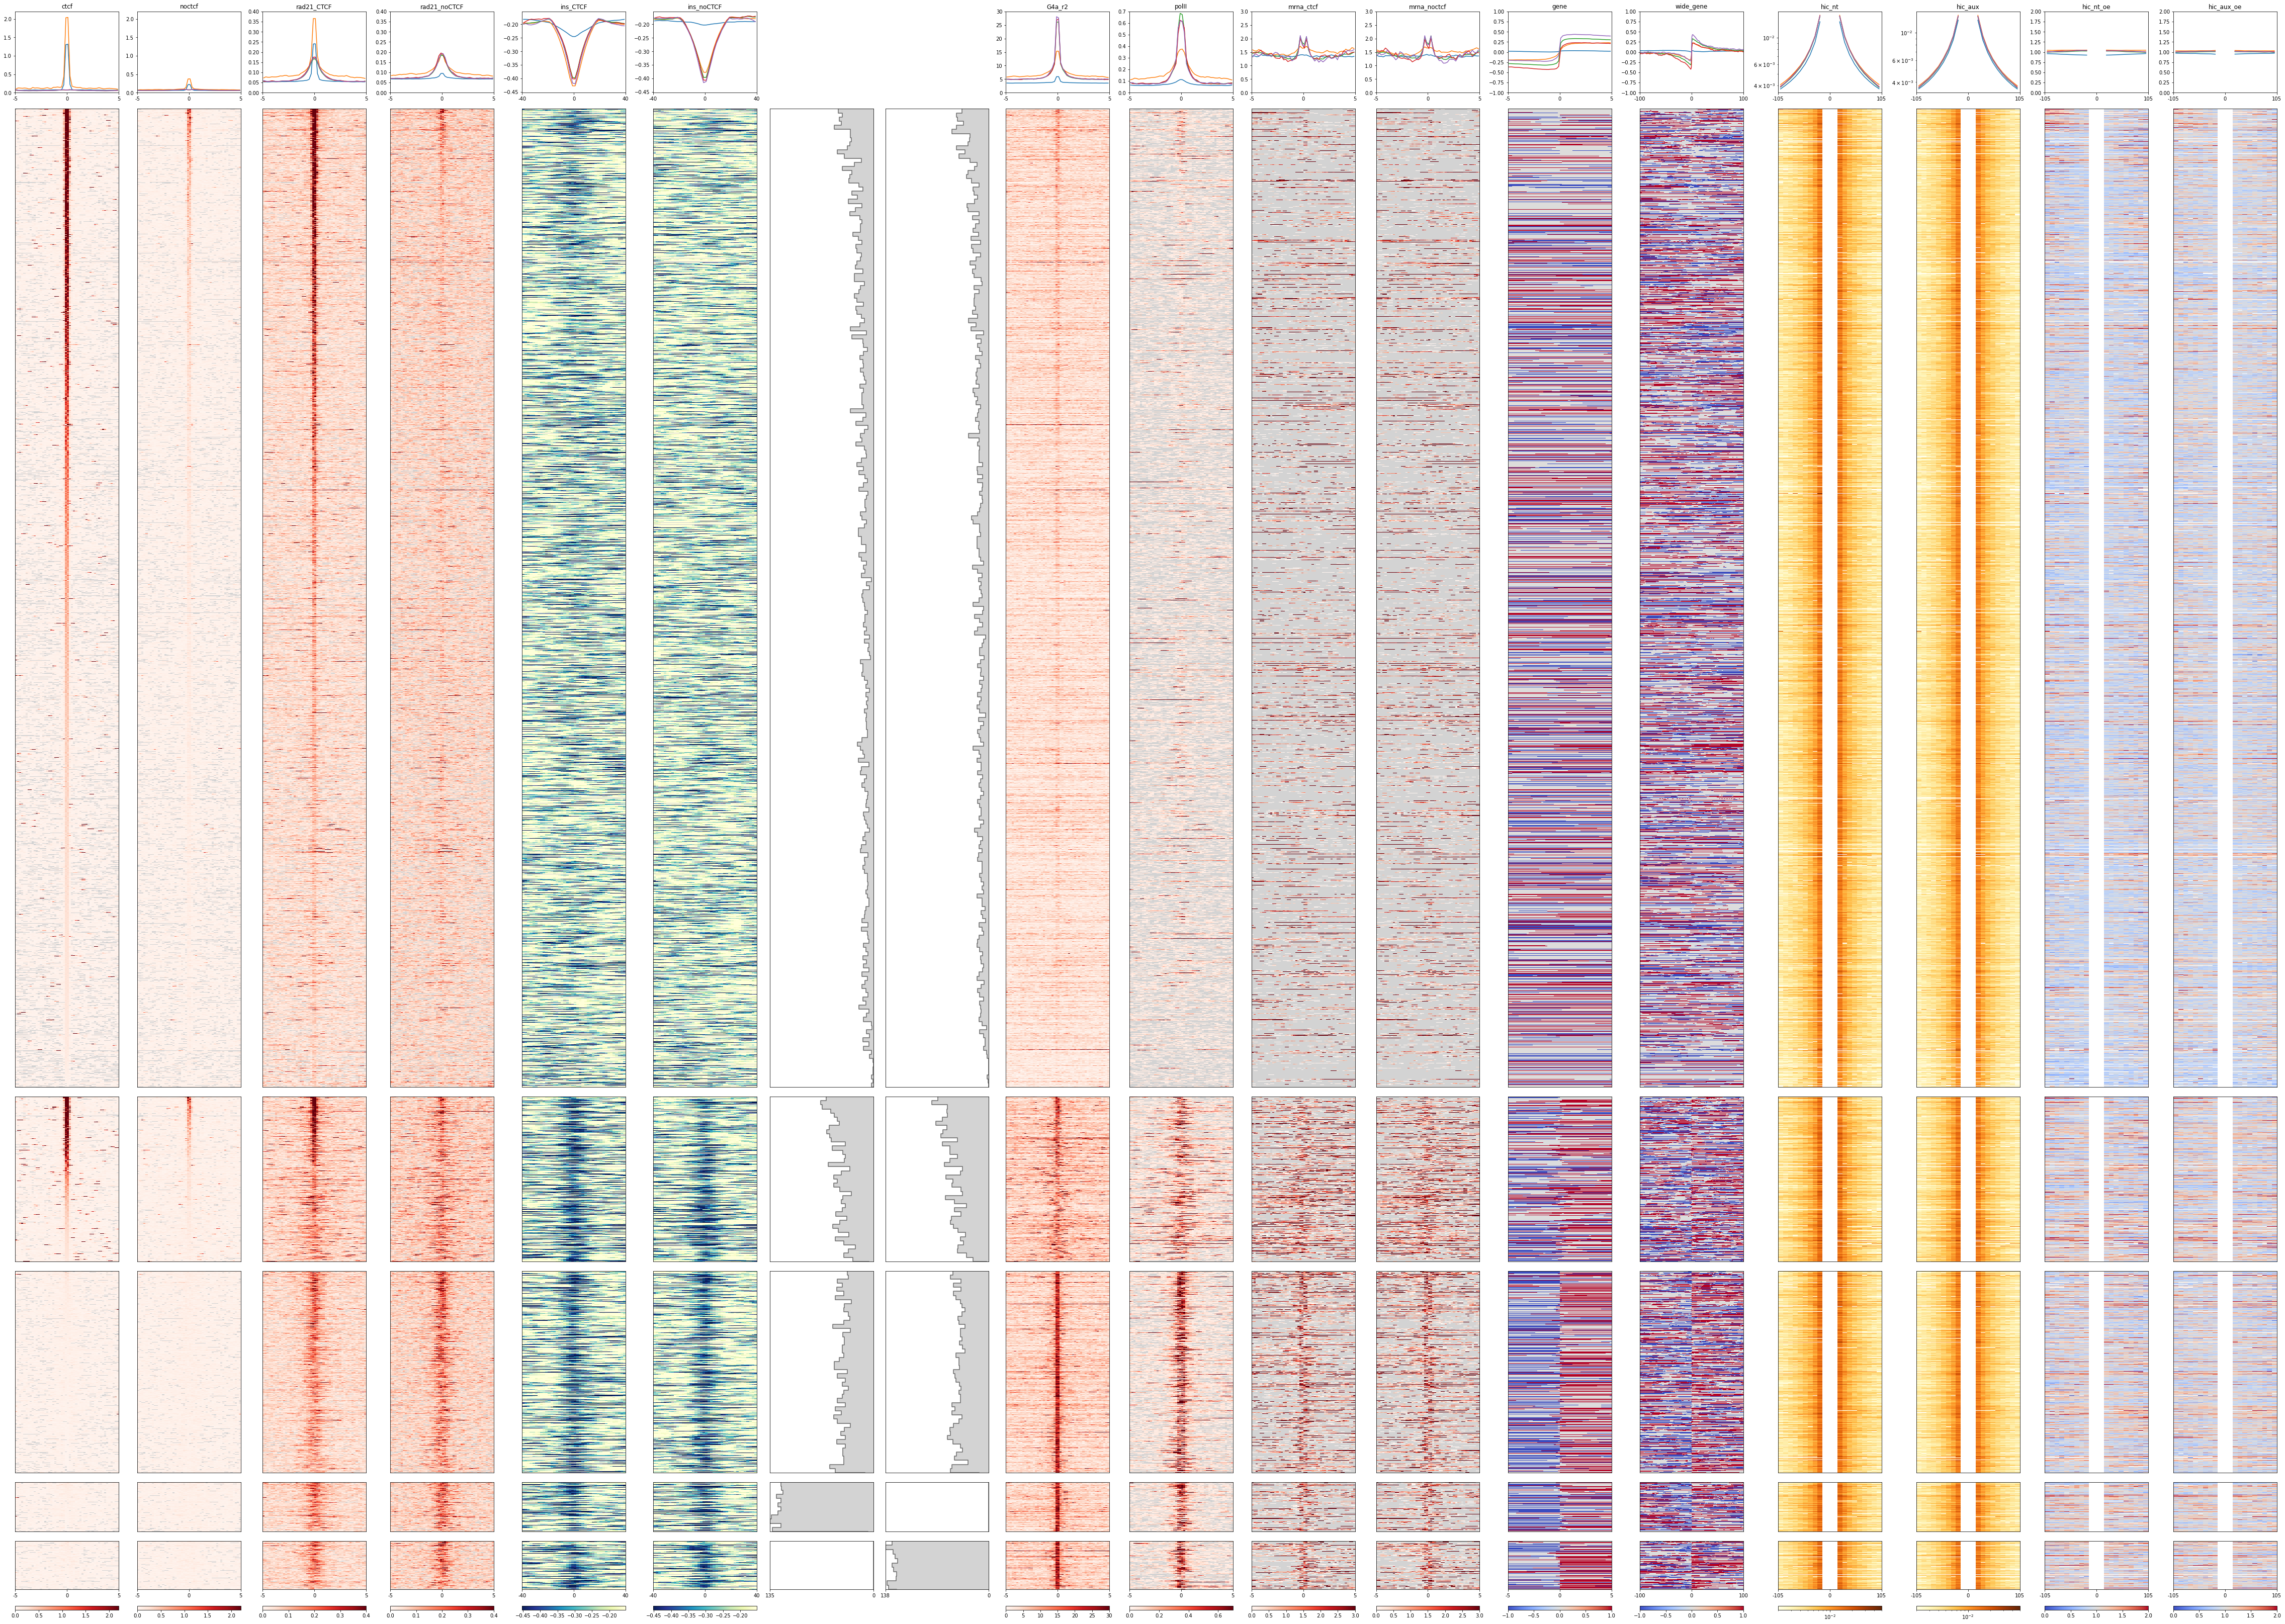

In [396]:
hmss = OrderedDict()

for feature_key in ['ctcf', 'ctcf_g4', 'g4', "g4p", "g4m"]:
    jjj = reordered_jdxs[feature_key]
    _stackups = stackup_dict[feature_key]
    hmss[feature_key] = [ _stackups[_k][jjj] for _k in fig2_samples ]

_limss = [ limss[_k] for _k in fig2_samples ]
_cmps = [ cmps[_k] for _k in fig2_samples ]
_binsizes = [ binsizes[_k] for _k in fig2_samples ]
_norms = [ norms[_k] for _k in fig2_samples ]

# xtra_plots = [1,2]
extra_order = [6,7]
hmss_order = [0,1,2,3,4,5,8,9,10,11,12,13,14,15,16,17]
xtra_axs = plot_stackups_sets(extra_order,hmss,titles,_limss,_cmps,_norms,_binsizes,extra_order=extra_order,hmss_order=hmss_order,fillmissing=False,interpolation="nearest")
# xtra_axs - 2 dimensional list of axes, first index - "column"; second index is row - i.e. the stackup group

# DEAL WITH XTRA PLOTS MANUALLY - AFTERWARDS ...

# y,width,color = Number_of_chunks, G4_polstall_sorted, "lightgrey"
# common_width_max = max(max(width[k]) for k in width)
# col_index = extra_order[0]
# for i, feature_key in enumerate(['ctcf', 'ctcf_g4', 'g4', "g4p", "g4m"]):
#     _y = np.arange(y[feature_key])
#     _width = width[feature_key]
#     _color = color
#     xtra_axs[col_index][i].step(_width,_y,color="dimgray")
#     xtra_axs[col_index][i].fill_betweenx(_y,0,_width,color=_color,step="post")
#     xtra_axs[col_index][i].invert_yaxis()
#     xtra_axs[col_index][i].invert_xaxis()
#     xtra_axs[col_index][i].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,pos: f"{int(x*100)}"))
#     xtra_axs[col_index][i].set_ylim(max(_y), 0)
#     xtra_axs[col_index][i].set_xlim(common_width_max,0)
#     xtra_axs[col_index][i].set_yticks([])
#     xtra_axs[col_index][i].set_yticklabels([])   
#     xtra_axs[col_index][i].set_xticks([])
#     xtra_axs[col_index][i].set_xticklabels([])   
# xtra_axs[col_index][i].set_xticks([common_width_max,0])
# xtra_axs[col_index][i].set_xticklabels([common_width_max,0])


for col_index, y, width, color in [(extra_order[0], Number_of_chunks, G4p_sorted, "lightgrey"),
                                    (extra_order[1], Number_of_chunks, G4m_sorted, "lightgrey")]:
    common_width_max = max(max(width[k]) for k in width)
    for i, feature_key in enumerate(['ctcf', 'ctcf_g4', 'g4', "g4p", "g4m"]):
        _y = np.arange(y[feature_key])
        _width = width[feature_key]
        _color = color
        xtra_axs[col_index][i].step(_width,_y,color="dimgray")
        xtra_axs[col_index][i].fill_betweenx(_y,0,_width,color=_color,step="post")
        xtra_axs[col_index][i].invert_yaxis()
        xtra_axs[col_index][i].invert_xaxis()
        xtra_axs[col_index][i].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,pos: f"{int(x*100)}"))
        xtra_axs[col_index][i].set_ylim(max(_y), 0)
        xtra_axs[col_index][i].set_xlim(common_width_max,0)
        xtra_axs[col_index][i].set_yticks([])
        xtra_axs[col_index][i].set_yticklabels([])   
        xtra_axs[col_index][i].set_xticks([])
        xtra_axs[col_index][i].set_xticklabels([])   
    xtra_axs[col_index][i].set_xticks([common_width_max,0])
    xtra_axs[col_index][i].set_xticklabels([common_width_max,0])

# annot_flank = 5000
# annot_binsize = 100
# col_index = extra_order[1]
# for i, feature_key in enumerate(['g4', "g4p", "g4m"]):
#     jjj = reordered_jdxs[feature_key]
#     feat_df = dfs[feature_key].loc[jjj]
#     aaa = rstacks(
#         "pcgene_plus.bb",
#         feat_df,
#         flank=annot_flank,
#         binsize=annot_binsize,
#     )
#     bbb = rstacks(
#         "pcgene_minus.bb",
#         feat_df,
#         flank=annot_flank,
#         binsize=annot_binsize,
#     )
#     xtra_axs[col_index][i].imshow(aaa-bbb,aspect="auto",interpolation="nearest",cmap="coolwarm",vmin=-1,vmax=1)
#     xtra_axs[col_index][i].set_xticks([])
#     xtra_axs[col_index][i].set_xticklabels([])   
#     xtra_axs[col_index][i].set_yticks([])
#     xtra_axs[col_index][i].set_yticklabels([])
# # ticks
# stack_width = aaa.shape[1]
# center_bin = stack_width/2 - .5
# flank_in_kb = int((center_bin+.5)*annot_binsize/1000)
# flank_ticks = [0-.5, center_bin, stack_width-.5]
# flank_ticklabels = [-flank_in_kb,0,flank_in_kb]
# xtra_axs[col_index][i].set_xticks(flank_ticks)
# xtra_axs[col_index][i].set_xticklabels(flank_ticklabels)

plt.savefig("Fig2.pdf")

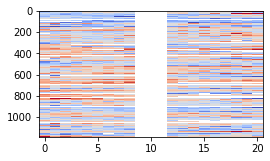

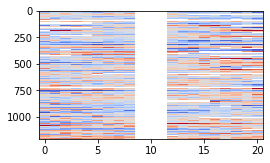

In [419]:
# ttt = stackup_dict["ctcf"]#.keys()
# aa = ttt['hic_nt_oe']
# bb = ttt['hic_aux_oe']
# plt.figure(figsize=(19,19))
# plt.imshow(bb/aa[reordered_jdxs["ctcf"]],aspect=0.01,interpolation="nearest",cmap="coolwarm",norm=colors.LogNorm(vmin=0.333,vmax=3))


ttt = stackup_dict["g4m"]#.keys()
aa = ttt['hic_nt_oe']
bb = ttt['hic_aux_oe']
plt.figure(figsize=(4,4))
plt.imshow(bb/aa[reordered_jdxs["g4m"]],aspect=0.01,interpolation="nearest",cmap="coolwarm",norm=colors.LogNorm(vmin=0.333,vmax=3))

ttt = stackup_dict["g4p"]#.keys()
aa = ttt['hic_nt_oe']
bb = ttt['hic_aux_oe']
plt.figure(figsize=(4,4))
plt.imshow(bb/aa[reordered_jdxs["g4p"]],aspect=0.01,interpolation="nearest",cmap="coolwarm",norm=colors.LogNorm(vmin=0.333,vmax=3))

In [77]:
# ###############################################################################
# ####
# #### LEGACY STACKUP PLOTTING SEPARATE FOR THE GROUPS ...
# ####
# ###############################################################################
# feature_key = 'ctcf'
# jjj = reordered_jdxs[feature_key]
# _stackups = stackup_dict[feature_key]
# hmss = [ _stackups[_k][jjj] for _k in fig2_samples ]
# _limss = [ limss[_k] for _k in fig2_samples ]
# _cmps = [ cmps[_k] for _k in fig2_samples ]
# _binsizes = [ binsizes[_k] for _k in fig2_samples ]
# _norms = [ norms[_k] for _k in fig2_samples ]

# xtra_plots = None
# plot_stackups(xtra_plots,hmss,titles,_limss,_cmps,_norms,_binsizes,fname=f"Fig2_{feature_key}.pdf",fillmissing=False,interpolation="nearest")

# feature_key = 'ctcf_g4'
# jjj = reordered_jdxs[feature_key]
# _stackups = stackup_dict[feature_key]
# hmss = [ _stackups[_k][jjj] for _k in fig2_samples ]
# _limss = [ limss[_k] for _k in fig2_samples ]
# _cmps = [ cmps[_k] for _k in fig2_samples ]
# _binsizes = [ binsizes[_k] for _k in fig2_samples ]
# _norms = [ norms[_k] for _k in fig2_samples ]

# xtra_plots = None
# plot_stackups(xtra_plots,hmss,titles,_limss,_cmps,_norms,_binsizes,fname=f"Fig2_{feature_key}.pdf",fillmissing=False,interpolation="nearest")

# feature_key = 'g4'
# jjj = reordered_jdxs[feature_key]
# _stackups = stackup_dict[feature_key]
# hmss = [ _stackups[_k][jjj] for _k in fig2_samples ]
# _limss = [ limss[_k] for _k in fig2_samples ]
# _cmps = [ cmps[_k] for _k in fig2_samples ]
# _binsizes = [ binsizes[_k] for _k in fig2_samples ]
# _norms = [ norms[_k] for _k in fig2_samples ]

# xtra_plots = None
# plot_stackups(xtra_plots,hmss,titles,_limss,_cmps,_norms,_binsizes,fname=f"Fig2_{feature_key}.pdf",fillmissing=False,interpolation="nearest")

In [18]:
# # check what we have here locally ...
# ! ls Fig2*pdf
# ! ssh ghpcc ls /nl/umw_job_dekker/users/sv49w/ALV2021
# ! scp Fig2* ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# !scp masterlist*.bed ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/

### testing bigBed with super simple gene annotation data ...

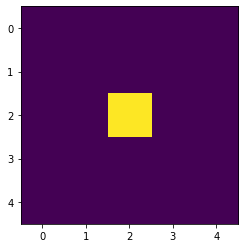

In [19]:
_k = np.ones((5,5))
_k[2,2] = 2
plt.imshow(_k)

In [20]:
from scipy.ndimage import convolve
bbb=convolve(np.clip(aaa.astype(float),0,1), _k, mode='constant', cval=0.0)

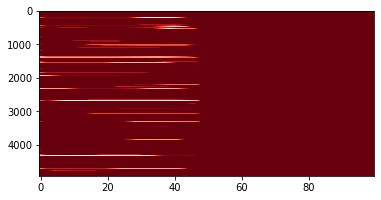

In [21]:
plt.imshow(bbb,aspect=0.01,cmap="Reds",vmin=0,vmax=1)

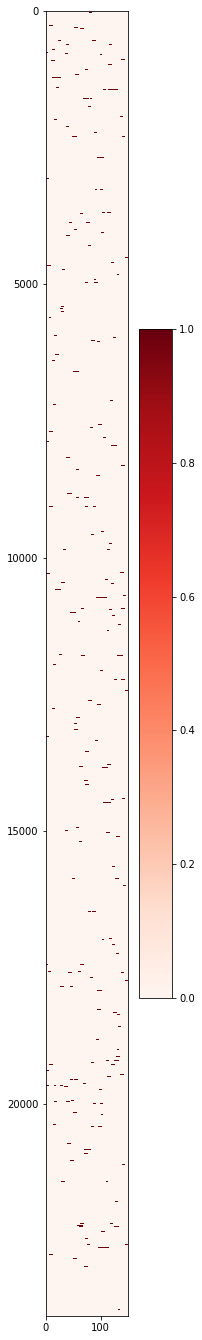

In [22]:
# SpliceDDX55aux.bb
# SpliceCTCFaux.bb
aaa = rstacks(
    "SpliceCTCFaux.bb",
    dfs["ctcf"],
    flank=15_000,
    binsize=200
)[reordered_jdxs["ctcf"]].astype(float)
bbb=convolve(np.clip(aaa.astype(float),0,1), _k, mode='constant', cval=0.0)
plt.figure(figsize=(4,24))
plt.imshow(bbb,aspect=0.1,interpolation="nearest",cmap="Reds",vmin=0,vmax=1)
plt.colorbar()

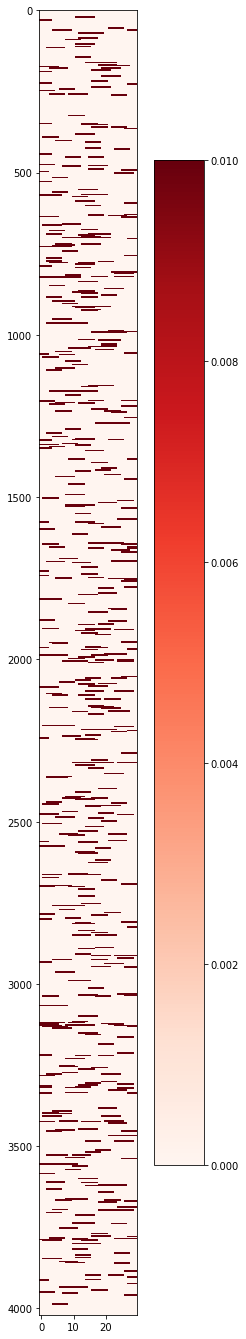

In [23]:
aaa = rstacks(
    "SpliceCTCFaux.bb",
    dfs["ctcf_g4"],
    flank=15_000,
    binsize=1_000
)[reordered_jdxs["ctcf_g4"]]
plt.figure(figsize=(6,24))
bbb=convolve(np.clip(aaa.astype(float),0,1), _k, mode='constant', cval=0.0)
plt.imshow(bbb,aspect=0.1,interpolation="none",cmap="Reds",vmin=0,vmax=.01)
plt.colorbar()

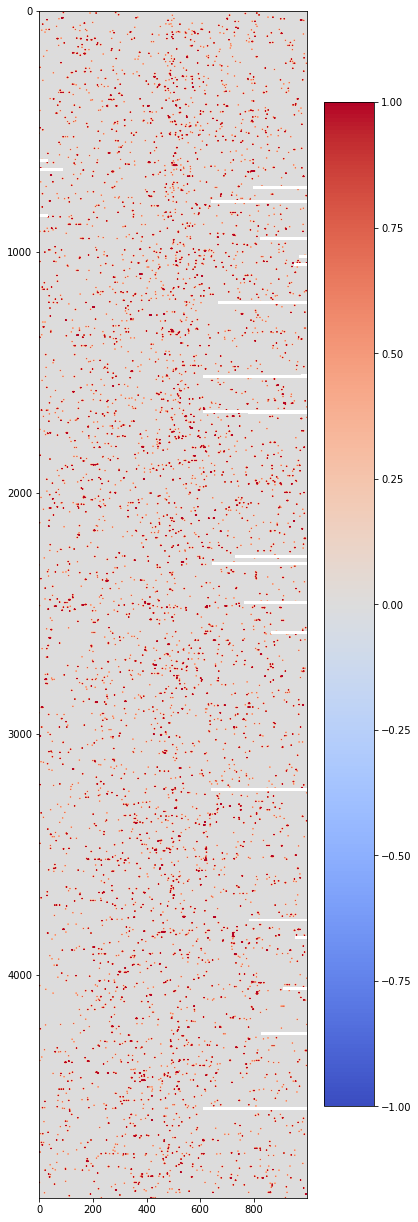

In [24]:
aaa = rstacks(
    "SpliceCTCFaux.bb",
    dfs["g4"],
    flank=250_000,
    binsize=500
)[reordered_jdxs["g4"]]
plt.figure(figsize=(6,42))
bbb=convolve(np.clip(aaa.astype(float),0,1), _k, mode='constant', cval=0.0)
plt.imshow(bbb,aspect=0.9,interpolation="bilinear",cmap="coolwarm",vmin=-1,vmax=1)
plt.colorbar()

In [351]:
# ## SCRAPE ALL OF THE ARM-LEVEL EXPECTED WORK FOR NOW:

# # calculate expected for the regions of interest:
# # this is a 10kb cooler file
# # and we should also have expected calculated for 10kb:
# !cooltools compute-expected \
#     --nproc 3 \
#     --output {fname}.10kb.exp.tsv \
#     --regions autosomal_hg19_arms.bed \
#     --contact-type cis \
#     --balance \
#     --weight-name weight \
#     --ignore-diags 2 \
#     {clr_uri}

# cis_exp = pd.read_csv("CkoCT442-NT-pool.mcool.10kb.exp.tsv",index_col=None,sep="\t")
# grp = cis_exp.groupby("region")

# grp.get_group("chr19_p").set_index("diag")["balanced.avg"][:20]

# import cooltools
# cooltools.lib.assign_regions(dfs["g4"],hg19_arms)

# flk = 5
# idx = clr.offset((c,s,e))
# mmm = clr.matrix()[idx,idx-flk:idx+flk+1][0]
# plt.plot(mmm,'o-')
# plt.plot(np.arange(len(mmm))[-flk-1:],mmm[-flk-1:])
# plt.plot(np.arange(len(mmm))[:flk+1],mmm[:flk+1])

# eee = grp.get_group("chr19_p").set_index("diag")["balanced.avg"].values[:flk+1]
# eee = np.r_[eee[::-1],eee[1:]]
# plt.plot(eee,'o-')



# # _k = "ctcf"
# # dfg4 = copy(dfs[_k])
# # anchor_center = 0.5*(dfs[_k]["start"]+dfs[_k]["end"])
# # anchor_center_binaligned = .5*(dfs[_k]["start"]+dfs[_k]["end"])
# # anchor_center_binaligned = clr.binsize * (anchor_center_binaligned/clr.binsize).astype(int)
# # dfg4["start"] = anchor_center_binaligned
# # dfg4["end"] = anchor_center_binaligned+clr.binsize # edge effects isn't fully solved

# # flank_bins = 20
# # mat = np.zeros((2*flank_bins+1,len(dfg4)),"float")

# # _regs = bioframe.expand(
# #     copy(dfg4),
# #     flank_bins*clr.binsize,
# #     limits=clr.chromsizes.to_dict(),
# # )

# # feats = cooltools.lib.assign_regions(_regs,hg19_arms)
# # fgrp = feats.groupby("region")

# # for reg, gdf in fgrp:
# #     # grab a matching expected
# #     _eee = grp.get_group(reg).set_index("diag")["balanced.avg"][:flank_bins+1]
# #     _eee = np.r_[ _eee[::-1], _eee[1:] ]
# #     for n in gdf.itertuples(index=True):
# #         i,c,s,e,_ = n
# #         ifrom, ito = clr.extent((c,s,e))
# #         # look up the real center-bin:
# #         _c,_s,_e = dfg4.loc[i]
# #         # icenter = int(0.5*(ifrom+ito))
# #         icenter = clr.offset((_c,_s,_e))
# #         # to be rewritten using fetch at the end ...
# #         # mat[:,i] = clr.matrix()[icenter,ifrom:ito][0]#/_eee
# #         mat_row = clr.matrix()[icenter-1:icenter+2,ifrom:ito].mean(axis=0)
# #         left_half = (ifrom - icenter + flank_bins, 0 + flank_bins)
# #         right_half = (0 + flank_bins, ito - icenter + flank_bins)
# #         #
# #         mat[slice(*left_half),i] = mat_row[:(icenter - ifrom)]
# #         mat[slice(*right_half),i] = mat_row[(icenter - ito):]
